# Few Shot Learning- Model

**Notebook內容：**
1. 先備知識
2. 模型/演算法
3. 參考資料(連結+連結說明)

## 1.先備知識

### 1.1 Few Shot Learning

* 因為target訓練資料不足，而導致模型訓練有over-fitting, under-fitting的情況
* 訓練框架: Transfer Learning
    * 透過在source dataset訓練而學會較好的特徵萃取，在target資料上期望能取得更好的performance
* 訓練框架: Meta Learning
    * 將source dataset形成多個task學習好的特徵比較或者好的更新方式等等，在target資料上期望能取得更好的performance
* 作法: Metric based Transfer Learning/Meta Learning

### 1.2 Metric base前情提要

* 混合similarity、distance這些固定準則加入network中估計output、而非直接學習類別本身
* 將data embed到一個高維空間中
* 同種類相似度高(距離近)，不同種類相似度低(距離遠)
* 比較種類參考資料(support)和待測資料(query)間的距離或相似度就能預測待測資料屬於哪個種類

## 2.模型/演算法

這邊使用的model都經過兩個步驟: 
* Embedding Learning- 學習使用backbone model基本特徵萃
* Adaptation- 讓backbone model及head model更適應於target data的訓練

這邊分Head, Model , Loss三部分介紹可能增加小資料訓練強度的方案

In [1]:
import os

import torch
from torch import nn

### 2.1 Cell

一些可能的building blocks，這邊是從頭train model，:
* 有normalization, activation, pooing 的Convolution層
* 有normalization, activation 的Dense層

In [2]:
# convolution cell
class conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super().__init__()
        self.cell=nn.Sequential(
            nn.Conv2d(ch_in, ch_out, 3, 1, 1),
            nn.InstanceNorm2d(ch_out),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )
    def forward(self,x):
        return self.cell(x)
    
# dense cell: 
class dense(nn.Module):
    def __init__(self,ch_in=512,ch_out=512,squeeze_input=False):
        super().__init__()
        self.cell=nn.Sequential(
            nn.Linear(ch_in, ch_out),
            nn.BatchNorm1d(ch_out),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.squeeze_input=squeeze_input
    def forward(self,x):
        if self.squeeze_input:
            return self.cell(x.squeeze())
        return self.cell(x)

### 2.2 Backbone

* 做feature extraction的部分。

* 這邊簡單兜一個CNN而已，也可以使用一些pre-train backbone, 如efficient net, resnet等等

* 簡單CNN結構: 
    * 數層Convolution cell
    * 用Global average pooling平均每個feature map的local訊息
    * 最後加一個dense cell投射到指定的latent space

In [3]:
class FeatureExtractor(nn.Module):
    def __init__(self,
                 in_features=3,
                 latent_features=3,
                 hidden_featrues=(64,128,256)):
        super().__init__()
        self.blocks = nn.Sequential(
            conv(3,hidden_featrues[0]),
            *[conv(ch1, ch2) for ch1,ch2 in zip(hidden_featrues[:-1],hidden_featrues[1:])],
            nn.AdaptiveAvgPool2d((1,1)),
            dense(hidden_featrues[-1],latent_features,squeeze_input=True)
        )
    def forward(self, x):
        return self.blocks(x)

### 2.3 Head

* 將latent space做切分用以分類的Output layer
* 不同的方法在output head差很多:
    1. Transfer Learning:
        * 普通的dense layer output head, 將weight與前層feature相乘加上bias而已，可能會使用各種loss訓練，torch的CCE有附softmax
        * nn.Linear
    3. Siamese Networks:
        * 不需要weight, 因為計算相似度或距離的來源是support照片本萃取出的latent vector
        * 這邊不放nn.Module，在Model上定義計算方式即可
    4. N-Way-K-Shot Support(以Prototypical Network為例)
        * 不需要weight, 因為計算相似度或距離的來源是support照片本萃取出的latent vector
        * 這邊不放nn.Module，在Model上定義計算方式即可
    2. Baseline++:
        * 每個類別有自己代表的latent vector,將latent vector與前層feature計算相似度或距離(metric)，可能會使用各種loss訓練
        * CosineLayer(客製化) - 這邊使用cosine simmilarity做為metric，另有euclidien distance供參考

**這邊有提供計算distance的方式**

In [4]:
import torch.nn.functional as F
# 計算cosine similarity
def cosine(x,w):
    return F.linear(F.normalize(x,dim=-1), F.normalize(w,dim=-1))
# 也可以用其他metric如eucidien distance, 不過要配合不同的loss
def euc_dist(x,w):
    return F.pairwise_distance(x, w, 2)

### 2.4 Model
* 組合各部件為完整分類模型
* 不同方法在output上有差別:
    * Siamese Networks: 
        * 將兩個data丟進backbone得到latetent
        * 將兩個latent計算相似度做為output
        * output logits是相似度
    * Prototypical Network: 
        * 將N*K support還有query全部丟進backbone得到latent
        * 每個support做K shot平均成為prototype
        * 將每個prototype與query計算相似度做為output
    * baseline++ (與Transfer Learning一樣): 
        * 將backbone output接至head
        * output logits在baseline++上是相似度

In [5]:
WAYS=6
SHOTS=5

class ClasModel(nn.Module):
    def __init__(self,ways,shots,backbone,head,metric=cosine):
        super().__init__()
        self.ways=ways
        self.shots=shots

        self.backbone=backbone
        self.head=head
        self.metric=metric

#### 2.4.1 Fine-tuning(對照組, 作為baseline): (Transfer Learning)
* Embedding Learning- 
    * 透過source dataset 訓練所有類別的分類
    * 目標為區分source dataset所有類別
* Adaptation- 換掉head, 再透過target dataset training

In [6]:
class Baseline(ClasModel):
    def __init__(self,ways,backbone,head):
        assert(backbone is not None)
        super().__init__(ways,None,backbone,head)
    def forward(self,data,label=None):
        # Transfer Learing: backbone+ output head
        hidden=self.backbone(data)
        logits=self.head(hidden)
        return logits

In [7]:
# Vanilla Transfer Learning
latent_dims=2
backbone=FeatureExtractor(latent_features=latent_dims)
head=nn.Linear(latent_dims,WAYS)
mode="transfer"
model=Baseline(WAYS,backbone,head)

x=torch.empty((8,3,28,28),dtype=torch.float32)
logit=model(x)
print("Latent shape(One batch):",model.backbone(x).shape)
print("Output shape:",logit.shape)

Latent shape(One batch): torch.Size([8, 2])
Output shape: torch.Size([8, 6])


#### 2.4.2 Siamese Networks: (Metric-based Meta Learning)
* Embedding Learning-  
    * 將source dataset中資料拆成兩兩一對的pairs training
    * 目標是訓練萃取後特徵的對比，同class相近，異class遠離
* Adaptation- 無，直接比較target dataset資料中support與query的部分透過backbone萃取的特徵是否足夠相近

<img src=https://i.imgur.com/jK98zOa.png  width="600" height="300">

In [8]:
class SiameseNet(ClasModel):
    def __init__(self,backbone,metric=cosine):
        super().__init__(2,None,backbone,None,metric)
    def forward(self,data,label=None):
        # 進Embedding
        latent=[*map(self.backbone,data.transpose(0,1))]
        # latent算metric 這邊用cosine
        logits=torch.stack([*map(self.metric,latent[0],latent[1])],dim=0)
        return logits

In [9]:
# Siamese Networks with cosine metric
latent_dims=5
backbone=FeatureExtractor(latent_features=latent_dims)
mode="siamese"
model=SiameseNet(backbone,cosine)
x=torch.empty((8,2,3,28,28),dtype=torch.float32)
logit=model(x)
print("Latents shape(One meta batch):",model.backbone(x[0]).shape)
print("Output shape:",logit.shape)

Latents shape(One meta batch): torch.Size([2, 5])
Output shape: torch.Size([8])


#### 2.4.3 Prototypical Network: (Metric-based Meta Learning)
* Embedding Learning-  將source dataset中資料拆成好幾個task
    * 每個task有N個class分別抽K個資料
    * 目標是訓練萃取後特徵的對比，同class相近(要是N個類別內最近的)，異class遠離
* Adaptation- 無，直接比較target dataset資料中support與query的部分

<img src=https://i.imgur.com/wLdemUU.png  width="600" height="400">

In [10]:
class PrototypicalNet(ClasModel):
    def __init__(self,ways,shots,backbone,metric=cosine):
        super().__init__(ways,shots,backbone,None,metric)
    def meta_forward(self,dataset,label=None):
        # 全部進embedding
        latent=torch.stack([*map(self.backbone,dataset)],dim=0)
        latent_q,latent_s=latent[:,self.ways*self.shots:],latent[:,:self.ways*self.shots]
        # 計算 prototypes
        latent_proto=torch.stack([torch.mean(l,dim=1) for l in torch.split(latent_s,self.shots,dim=1)],dim=1)
        logits=torch.cat([*map(self.metric,latent_q,latent_proto)],dim=0)
        return logits
    def save_prototypes(self,dataset):
        with torch.no_grad():
            latent_s=self.backbone(dataset)
            self.latent_proto=torch.stack([torch.mean(l,dim=0) for l in torch.split(latent_s,self.shots,dim=0)],dim=0).detach()
    def forward(self,data,label=None):
        latent_q=self.backbone(data)[:,np.newaxis,...]
        logits=torch.cat([self.metric(self.latent_proto,qq).transpose(0,1) for qq in latent_q],dim=0)
        return logits

In [11]:
# Prototypical Network with cosine metric

mode="proto"
model=PrototypicalNet(WAYS,SHOTS,backbone,cosine)
x=torch.empty((8,WAYS*SHOTS+1,3,28,28),dtype=torch.float32)
logit=model.meta_forward(x)
print("Latents shape(One meta batch):",model.backbone(x[0]).shape)
print("Output shape:",logit.shape)

Latents shape(One meta batch): torch.Size([31, 5])
Output shape: torch.Size([8, 6])


#### 2.4.4 Baseline++ : (Metric-based Transfer Learning)
* Embedding Learning- 
    * 透過source dataset training,訓練所有類別的分類
    * 目標為區分source dataset所有類別在latent space中的latent vector，各類別相應的latent vector會在過程中被訓練及儲存成weight
* Adaptation- 換掉head(或加上更多weight), 再透過target dataset training訓練新的類別在latent space上相應的latent vector位置
    * 不同類別latent vector間的distance要拉開
    * 或者是同類別latent vector間的similarity要拉近

<img src=https://i.imgur.com/SIGtTdV.png  width="700" height="300">

#### Supp. Cosine Similarity Output Layer

* 來自於Ring Loss, 就是對latent vector與output layer weight(support latent vector)算cosine simmilarity後再做Softmax
* 與原本dense+softmax相比，若將dense的矩陣乘法改為normalized矩陣相乘則等於計算cosine similarity，其效果是可以減少數量多的類別可能形成的domination
* 計算cosine 後再使用softmax

<img src=https://i.imgur.com/WU0MXS5.png  width="600" height="300">

* Layer計算公式:$ $
    * Dense Layer: $h=W^Tx+b$
        * $x\in N^{1\times D}$是latent vector
        * $W\in N^{N\times D}$為weight
        * b是bias, 
        * $h\in N^{1\times N}$是logit
    * Cosine Layer: $h=\frac{W^Tx}{|W||x|}=cos{\phi} $
        * h依然是logit，但可看作x與W裡面每個latent vector夾角$\phi$取cosine的值，也是相似度
        * $\phi\in N^{1\times N}$是夾角，相似度越大，夾角越小

In [12]:
# Cosine的layer
class MetricLayer(nn.Module):
    def __init__(self, n_in_features,n_out_features=10,metric=cosine):
        super().__init__()
        self.weight = nn.Parameter(torch.Tensor(n_out_features, n_in_features))
        nn.init.xavier_uniform_(self.weight,gain=1.0)
        self.metric=metric
    def forward(self,x):
        return self.metric(x,self.weight)

In [13]:
# Baseline++ with cosine metric

backbone=FeatureExtractor(latent_features=latent_dims)
head=MetricLayer(latent_dims,WAYS,cosine)
model=Baseline(WAYS,backbone,head)
x=torch.empty((8,3,28,28),dtype=torch.float32)
logit=model(x)
print("Latent shape(One batch):",model.backbone(x).shape)
print("Output shape:",logit.shape)

Latent shape(One batch): torch.Size([8, 5])
Output shape: torch.Size([8, 6])


### 2.5 Loss

* 定義計算output logits與label的誤差的方式。
* 這邊提供幾種loss:
    * Categorical Cross Entropy(CCE) -> (torch原生)可以給transfer learning, baseline++, prototypical network用
    * Focal Loss -> 加強正確類別的權重，可以給transfer learning, baseline++, prototypical network用
    * Contrastive Loss -> 可以給Siamese Network用，但這邊是給euclidien distance metric用的，若是cosine similarity則可直接用BCE
    * Add Margin Loss -> 人臉辨識家族CosineFace用的loss，拉開不同class的cosine值，給cosine metric用: baseline++, prototypical network
    * Arc Margin Loss -> 人臉辨識家族ArcFace用的loss，拉開不同class的徑度值(cosine裡面的那個角度)，給cosine metric用: baseline++, prototypical network

### 2.5.1 Special Loss for Transfer Learning
* Focal Loss: 降低easy case中loss gradient,增加hard case中loss gradient

<img src=https://i.imgur.com/u9OUrX2.png  width="400" height="250">

In [14]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, eps=1e-10):
        super().__init__()
        self.gamma = gamma
        self.eps = torch.tensor(eps,dtype=torch.float32)
        self.ce = nn.CrossEntropyLoss()
    def forward(self,  y_pred,y_true):
        # 計算cross entropy
        logp = self.ce(y_pred+self.eps, y_true)
        # 計算乘上gamma次方後的entropy反方機率(將對比放大)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()

### 2.5.2 Loss for Siamese Netwrok
* Contrastive Loss

In [15]:
class ContrastiveLoss(nn.Module):
    def __init__(self,m=1):
        super().__init__()
        self.m=m
        self.activation=torch.sigmoid
        self.loss_fn=nn.BCELoss()
        self.z=torch.tensor(0.,dtype=torch.float32,requires_grad=False)
    def forward(self, y_pred,y_true):
        # 兩者同組時，算square
        # 兩者不同組時，算margin- distance值，若distance大於margin則不用再拉伸兩者distance
        loss=torch.mean(y_true * torch.square(y_pred)+ 
                        (1 - y_true)* torch.square(torch.maximum(self.m - y_pred, self.z)
                        ),dim=-1,keepdims=True)
        return loss.mean()
        

### 2.5.3 Loss for Cosine logits

前述Baseline++是使用Metric based的方法來對待測image的latent vector與各類別support訓練出來的latent vector算cosine simillarity，並且在target task時可以訓練target類別的support latent vector。

那這個cosine similarity 也可以有更多種方式來緩和資料不平衡的影響及增強類別的區辨。

*  CosineMargin Loss

* 出自CosineFace, 先計算cosine simmilarity
* 在正確類別cosine值扣掉一個margin，使得訓練變得更困難，也使得每個類別的區分更明顯
(增加Way數大的時候的準確度)

<img src=https://i.imgur.com/75WvROU.png  width="600" height="300">

(借用L-Softmax的圖形)

In [16]:
class AddMarginLoss(nn.Module):
    def __init__(self, s=15.0, m=0.40,loss_fn=FocalLoss()):
        super().__init__()
        self.s = s
        self.m = m
        self.loss_fn=loss_fn
    def forward(self, cosine, label=None):
        # 扣掉對cosine的margin
        cos_phi = cosine - self.m
        # 將onehot沒選中的類別不套用margin，onehot選中的套用margin     
        one_hot=F.one_hot(label, num_classes=- 1).to(torch.float32)
        metric = (one_hot * cos_phi) + ((1.0 - one_hot) * cosine)
        # 將輸出對比放大
        metric *= self.s
        return self.loss_fn(metric,label)

* ArcMargin Loss
    * 出自ArcFace, 要先計算cosine simmilarity
    * 將正確類別cosine值轉成arc(角度)再加上一個margin，使得訓練變得更困難，也使得每個類別的區分更明顯
    * 另外也有其他使用margin的loss，都是在增加不同類別latent vecor間的角度，以下為列表
    <img src=https://i.imgur.com/SHyaRnc.png  width="400" height="150">
    * 使用margin對角度的影響如示意圖
    <img src=https://i.imgur.com/h1dFJ8z.png  width="500" height="150">

In [17]:
import math

class ArcMarginLoss(AddMarginLoss):
    def __init__(self, s=32.0, m=0.40, easy_margin=False,loss_fn=FocalLoss()):
        super().__init__(s,m,loss_fn)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)

        # make the function cos(theta+m) monotonic decreasing while theta in [0°,180°]
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m
        self.eps = 1e-6
    def forward(self, cosine, label=None):
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2) + self.eps)
        # cos(phi)cos(m)-sin(phi)sin(m)變成cos(phi + m)
        # 這個margin加上去使得角度phi需要更小才能使指定類別在softmax(cos(phi))時最大
        cos_phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            # cosine如果不夠大就不用不套用phi margin
            cos_phi = torch.where(cosine > 0, cos_phi, cosine)
        else:
            # 更加嚴格，若cosine(phi)大於margin則套用phi margin規則
            #          若cosine(phi)小於margin則套用cosine margin規則
            cos_phi = torch.where(cosine > self.th, cos_phi, cosine - self.mm)
            
        # 將onehot沒選中的類別不套用margin，onehot選中的套用margin    
        one_hot=F.one_hot(label, num_classes=- 1).to(torch.float32)
        metric = (one_hot * cos_phi) + ((1.0 - one_hot) * cosine)
        # 將輸出對比放大
        metric *= self.s
        return self.loss_fn(metric,label)

試看loss

In [18]:
cce=nn.CrossEntropyLoss()
focal_cce=FocalLoss(2,SHOTS)
contrastive=ContrastiveLoss(m=1)
addmarginloss=AddMarginLoss(s=2.0, m=0.40)
arcmarginloss=ArcMarginLoss(s=2.0, m=0.40)

In [19]:
yy=torch.tensor([0,1,2,3])
y_gt=F.one_hot(yy, num_classes=- 1).to(torch.float32)
y_best=y_gt-0.5+torch.randn((4,4),dtype=torch.float32)/100
y_good=y_gt-0.5+torch.randn((4,4),dtype=torch.float32)/10
y_noisy=y_gt-0.5+torch.randn((4,4),dtype=torch.float32)/3

In [20]:
contrastive(y_gt,y_noisy)

tensor(1.2272)

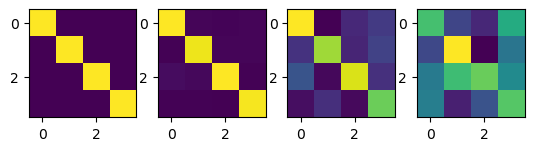

In [21]:
import matplotlib.pyplot as plt
plt.subplot(1,4,1);plt.imshow(y_gt)
plt.subplot(1,4,2);plt.imshow(y_best)
plt.subplot(1,4,3);plt.imshow(y_good)
plt.subplot(1,4,4);plt.imshow(y_noisy)

In [22]:
loss_cce=[cce(pred,yy).item() for pred in [y_gt,y_best,y_good,y_noisy]]
loss_focal=[focal_cce(pred,yy).item() for pred in [y_gt,y_best,y_good,y_noisy]]
loss_add=[addmarginloss(pred,yy).item() for pred in [y_gt,y_best,y_good,y_noisy]]
loss_arc=[arcmarginloss(pred,yy).item() for pred in [y_gt,y_best,y_good,y_noisy]]

In [23]:
print("best-------------good-------------noisy")
print("CCE:",loss_cce)
print("Focal:",loss_focal)
print("Addmargin:",loss_add)
print("Arcmargin:",loss_arc)

best-------------good-------------noisy
CCE: [0.7436683773994446, 0.7445589303970337, 0.7814091444015503, 0.8011915683746338]
Focal: [0.2046871930360794, 0.20526303350925446, 0.22975283861160278, 0.24342457950115204]
Addmargin: [0.1450444757938385, 0.14594729244709015, 0.18906809389591217, 0.28135576844215393]
Arcmargin: [0.04045689105987549, 0.13413764536380768, 0.17874965071678162, 0.25891777873039246]


Text(0, 0.5, 'normalized loss')

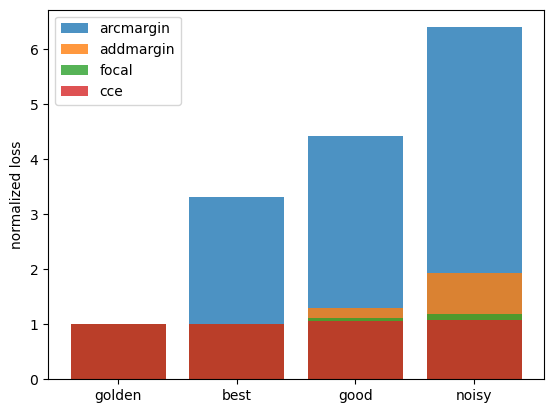

In [24]:
def div_first(x):
    return [*map(lambda h: h/x[0],x)]
labels=["golden","best","good","noisy"]
plt.bar(labels,div_first(loss_arc),alpha=0.8)
plt.bar(labels,div_first(loss_add),alpha=0.8)
plt.bar(labels,div_first(loss_focal),alpha=0.8)
plt.bar(labels,div_first(loss_cce),alpha=0.8)
plt.legend(["arcmargin","addmargin","focal","cce"])
plt.ylabel("normalized loss")

基本arcmargin與addmargin可以讓loss數值對錯誤答案敏感化

## 3.參考資料
* [Chen, W. Y., Liu, Y. C., Kira, Z., Wang, Y. C. F., & Huang, J. B. (2019). A closer look at few-shot classification. arXiv preprint arXiv:1904.04232.](https://arxiv.org/abs/1904.04232)
    - Baseline++ 原文(台大王鈺強老師團隊)
* [Bromley, J., Guyon, I., LeCun, Y., Säckinger, E., & Shah, R. (1993). Signature verification using a" siamese" time delay neural network. Advances in neural information processing systems, 6.](https://proceedings.neurips.cc/paper/1993/hash/288cc0ff022877bd3df94bc9360b9c5d-Abstract.html)
    - Siamese Networks原文
* [Snell, J., Swersky, K., & Zemel, R. S. (2017). Prototypical networks for few-shot learning. arXiv preprint arXiv:1703.05175.](https://arxiv.org/abs/1703.05175)
    - Prototypical networks原文
* [Lin, T. Y., Goyal, P., Girshick, R., He, K., & Dollár, P. (2017). Focal loss for dense object detection. In Proceedings of the IEEE international conference on computer vision (pp. 2980-2988). ](https://arxiv.org/abs/1708.02002v2)
    - Focal Loss原文
* [Wang, H., Wang, Y., Zhou, Z., Ji, X., Gong, D., Zhou, J., ... & Liu, W. (2018). Cosface: Large margin cosine loss for deep face recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 5265-5274).](https://arxiv.org/abs/1801.09414)
    - CosineFace原文
* [Deng, J., Guo, J., Xue, N., & Zafeiriou, S. (2019). Arcface: Additive angular margin loss for deep face recognition. In Proceedings of the IEEE/CVF conference on computer vision and pattern recognition (pp. 4690-4699).](https://arxiv.org/abs/1801.07698)
    - ArcFace原文
